In [1]:
# step by step using https://keras.io/api/preprocessing/image/
# and macpro_keras_example_test01 file

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
BATCH_SIZE = 10
IMG_SIZE = (300, 300)

In [14]:
train_dataset = image_dataset_from_directory("../../data_single/data_single_conv_split/train/",
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 569 files belonging to 2 classes.


In [15]:
validation_dataset = image_dataset_from_directory("../../data_single/data_single_conv_split/val/",
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 100 files belonging to 2 classes.


In [16]:
class_names = train_dataset.class_names
class_names

['par1', 'wt']

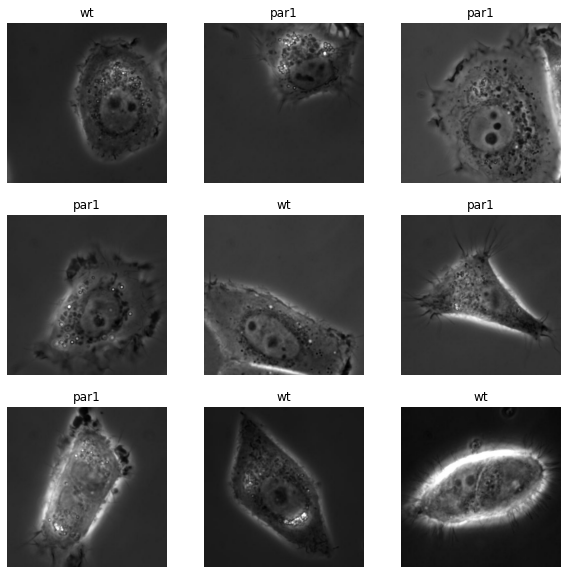

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [18]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [19]:
type(train_dataset.take(1))

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [20]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [21]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 8
Number of test batches: 2


In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE # use instead this in linux

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [23]:
data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

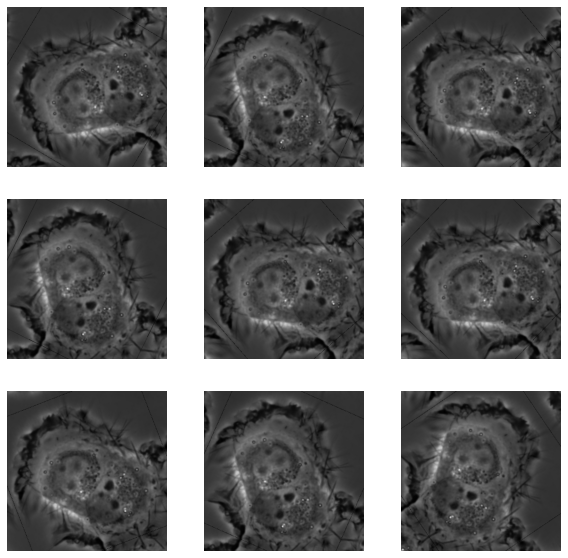

In [24]:
for image, _ in train_dataset.take(1):
      plt.figure(figsize=(10, 10))
      first_image = image[0]
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [25]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [26]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [27]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [28]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 10, 10, 1280)


In [29]:
base_model.trainable = False

In [30]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 301, 301, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [31]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 1280)


In [32]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 1)


In [34]:
inputs = tf.keras.Input(shape=(300, 300, 3)) # 300x300
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [35]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 300, 300, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 300, 300, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)             

In [37]:
len(model.trainable_variables)

2

In [38]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

8/8 [==============================] - 0s 13ms/step - loss: 0.8407 - accuracy: 0.4875


In [39]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.84
initial accuracy: 0.49


In [40]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
57/57 [==============================] - 15s 264ms/step - loss: 0.7473 - accuracy: 0.5185 - val_loss: 0.6171 - val_accuracy: 0.6750
Epoch 2/10
57/57 [==============================] - 2s 34ms/step - loss: 0.6860 - accuracy: 0.5606 - val_loss: 0.5755 - val_accuracy: 0.7250
Epoch 3/10
57/57 [==============================] - 2s 32ms/step - loss: 0.6618 - accuracy: 0.5870 - val_loss: 0.5557 - val_accuracy: 0.7000
Epoch 4/10
57/57 [==============================] - 2s 32ms/step - loss: 0.6588 - accuracy: 0.5923 - val_loss: 0.5394 - val_accuracy: 0.7000
Epoch 5/10
57/57 [==============================] - 2s 34ms/step - loss: 0.6192 - accuracy: 0.6292 - val_loss: 0.5168 - val_accuracy: 0.7125
Epoch 6/10
57/57 [==============================] - 2s 34ms/step - loss: 0.5996 - accuracy: 0.6397 - val_loss: 0.4818 - val_accuracy: 0.7375
Epoch 7/10
57/57 [==============================] - 2s 33ms/step - loss: 0.5743 - accuracy: 0.6960 - val_loss: 0.4954 - val_accuracy: 0.6875
Epoch 8/10


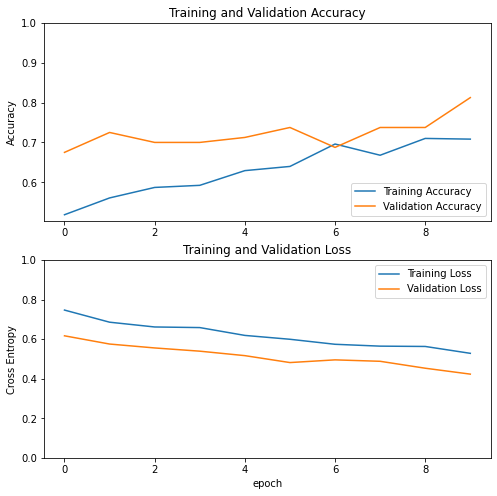

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Note: If you are wondering why the validation metrics are clearly better than 
# the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and 
# tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

In [42]:
base_model.trainable = True

In [43]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [44]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 300, 300, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 300, 300, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)             

In [46]:
len(model.trainable_variables)

58

In [47]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
57/57 [==============================] - 10s 183ms/step - loss: 0.4532 - accuracy: 0.7663 - val_loss: 0.2972 - val_accuracy: 0.9000
Epoch 11/20
57/57 [==============================] - 2s 36ms/step - loss: 0.3543 - accuracy: 0.8471 - val_loss: 0.3013 - val_accuracy: 0.9375
Epoch 12/20
57/57 [==============================] - 2s 36ms/step - loss: 0.3016 - accuracy: 0.8735 - val_loss: 0.2290 - val_accuracy: 0.8875
Epoch 13/20
57/57 [==============================] - 2s 34ms/step - loss: 0.2728 - accuracy: 0.8787 - val_loss: 0.1927 - val_accuracy: 0.9625
Epoch 14/20
57/57 [==============================] - 2s 33ms/step - loss: 0.2152 - accuracy: 0.9139 - val_loss: 0.2490 - val_accuracy: 0.8500
Epoch 15/20
57/57 [==============================] - 2s 34ms/step - loss: 0.2175 - accuracy: 0.9069 - val_loss: 0.1876 - val_accuracy: 0.9125
Epoch 16/20
57/57 [==============================] - 2s 35ms/step - loss: 0.1793 - accuracy: 0.9156 - val_loss: 0.1704 - val_accuracy: 0.9375
Epoc

In [48]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

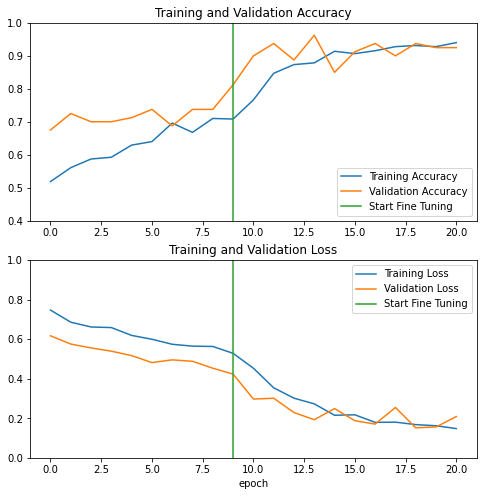

In [51]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [52]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 0s 12ms/step - loss: 0.1884 - accuracy: 0.9500
Test accuracy : 0.949999988079071


Predictions:
 [0 0 1 0 1 0 0 1 1 0]
Labels:
 [1 0 0 0 1 1 0 1 1 0]


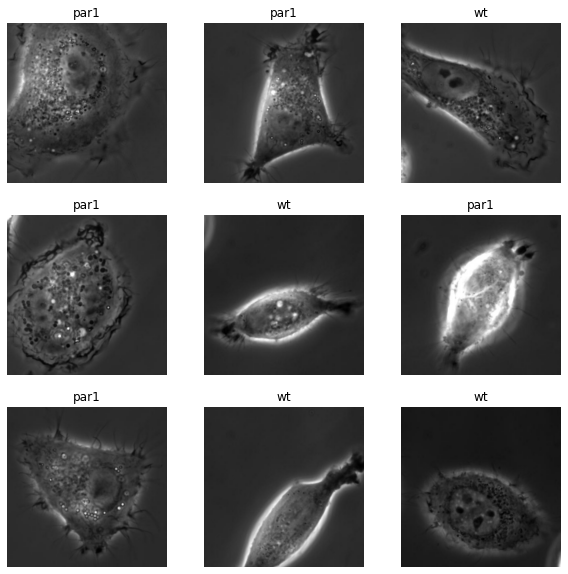

In [53]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")